<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/PEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de Escalonamento de Veículos

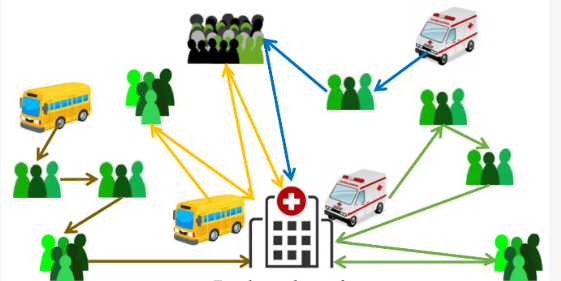

## Introdução

O problema de escalonamento de veículos (VSP) está relacionado com o agendamento de um número de veículos que devem visitar um número de locais para pegar ou entregar mercadorias ou realizar algum serviço. Os termos "veículo" e
"local" foram usados para fornecer uma cenário, mas muitas aplicações do modelo PEV têm nada a ver com veículos reais visitando locais. O problema é algumas vezes referido na literatura como o problema do despacho do caminhão, roteirização do transporte, roteamento de veículos, ou o problema de entrega.

Fonte: C.D.T. WATSON-GANDY, **THE VEHICLE SCHEDULING PROBLEM: A SURVEY**. Operations Research Society of New Zealand, 1981.

### Definição do problema

Vamos considerar que temos como entrada um grafo $G = (V, A)$ completo no qual um nó específico é chamado de depósito. Os demais nós do grafo são os clientes. Para qualquer arco $(u,v) \in A$, vamos considerar conhecida uma métrica $t(u,v)$ o tempo de deslocamento entre os nós $u$ e $v$. 

Além disso temos um conjunto de tarefas $J$, cada uma delas com uma data de início $d_j$ e uma duração de execução $p_j$. Estas tarefas possuem também uma sequência de nós $S_j$ que devem ser visitados para cumprir a tarefa. 

Com uma frota limitada em $R$ veículos, queremos determinar qual é o conjunto de rotas a serem repartidas entre eles de forma a atender todas as tarefas com um atraso total mínimo.

Por simplicidade, vamos reproduzir o que foi realizado no problema do caixeiro viajante e considerar que cada vértice do grafo é um ponto num espaço euclidiano $\mathbb{R}^2$ e que a métrica de tempo é a própria distância euclidiana.

In [ ]:
import matplotlib.pyplot as plt
import math
import random
import time
import itertools
import urllib
import csv

In [ ]:
distancia = math.dist

In [ ]:
class Tarefa:
  def __init__(self):
    self.index: int = 0
    self.data: float = 0
    self.duracao: float = 0
    self.seq:list[tuple[int, int]] = []
  
  def duracao_total(self):
    return self.duracao + tamanho_rota(self.seq)
  
  def __repr__(self):
    return f"Data = {self.data}\tDuracao = {self.duracao_total()}\t Rota = {self.seq}"
  def __str__(self):
    return f"Data = {self.data}\tDuracao = {self.duracao_total()}\t Rota = {self.seq}"
  
class PEV:
  def __init__(self):
    self.clientes:list[tuple[int, int]] = []
    self.tarefas:list[Tarefa] = []
    self.R:int = 0
    self.rotas: list[list[Tarefa]] = []

  def atraso_rota(self, r: int):
    atraso = 0.
    t = 0.
    local = self.clientes[0]
    for i in range(len(self.rotas[r])):
      t += distancia(local, self.rotas[r][i].seq[0])
      atraso += max(t - self.rotas[r][i].data, 0)
      t += self.rotas[r][i].duracao_total()
      local = self.rotas[r][i].seq[-1]
    return atraso

  def atraso_total(self):
    return sum(self.atraso_rota(r) for r in range(self.R))

  def __repr__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.atraso_total()}"
  def __str__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.atraso_total()}"

In [ ]:
def tamanho_rota(rota):
  "A distância total percorrida entre dois pares consecutivos em uma rota"
  return sum(distancia(rota[i-1], rota[i]) for i in range(len(rota)))

### Construindo instâncias fictícias

In [ ]:
import copy

def gerar_pev (n: int, r: int, t: int, largura=1000, altura=1000, rseed=233):
  """Cria uma instância do PEV com n clientes, r veículos e t tarefas 
  com coordenadas aleatórias no máximo (largura x alutura)"""
  pev = PEV()
  random.seed(rseed)
  pev.R = r
  
  pev.clientes = [ (largura//2 + (2*random.randrange(2)-1)*random.randrange(largura//2-100), 
                    altura//2 + (2*random.randrange(2)-1)*random.randrange(altura//2-100)) 
                    for c in range(n+1) ]
  pev.clientes[0] = (largura//2, altura//2)

  intervalos = t//r
  
  for j in range(t):
    tar = Tarefa()
    tar.index = j
    tar.data = max(0, random.randrange(intervalos)*500 + random.randrange(200)- 100)
    tar.duracao = random.randrange(100)
    pev.tarefas.append(tar)

  faltantes = copy.deepcopy(pev.clientes[1:])
  while(faltantes):
    if (t < len(faltantes)):
      clientes_sorteados = random.sample(faltantes, t)
      for j in range(t):
        pev.tarefas[j].seq.append(clientes_sorteados[j])
      for x in clientes_sorteados: faltantes.remove(x)  
    else:
      for c in faltantes:
        j = random.randrange(t)
        pev.tarefas[j].seq.append(c)
      break
        
  for x in range(r): pev.rotas.append([])

  return pev


In [ ]:
gerar_pev(30, 4, 40)

Clientes = 30	Veiculos = 4	Custo = 0.0

### Desenhando a solução

In [ ]:
def plot_rota(deposito, rota, cor):
  x = []
  y = []
  text = []
  style = []

  x.append(deposito[0])
  y.append(deposito[1])
  text.append('')
  style.append('dashed')
  for i in range(len(rota)):
    for j in range(len(rota[i].seq)):
      x.append(rota[i].seq[j][0])
      y.append(rota[i].seq[j][1])
      text.append(rota[i].index)
      if (j < len(rota[i].seq)-1):
        style.append('solid')
      else:
        style.append('dashed')

  for i in range(len(x)):
    plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=cor, linewidth=2, linestyle=style[i-1])
  
  plt.scatter(x, y, color=cor, linewidth=10)

  # Loop for annotation of all points
  for i in range(len(x)):
    plt.annotate(text[i], (x[i]-10, y[i]-10 ))


In [ ]:
import seaborn as sns;
def plot_pev(pev):

  print(pev)

  palette = itertools.cycle(sns.color_palette("colorblind", pev.R))
  for rota in pev.rotas:
    plot_rota(pev.clientes[0], rota, next(palette))
  
  plt.plot(pev.clientes[0][0], pev.clientes[0][1], 
           marker="D", markersize=10, markeredgecolor="black", markerfacecolor="grey")
  plt.axis("scaled")

  plt.show()


Data = 1050	Duracao = 1409.9271897097553	 Rota = [(211, 531), (883, 567)]
Data = 0	Duracao = 42.0	 Rota = [(472, 101)]
Data = 519	Duracao = 25.0	 Rota = [(710, 295)]
Data = 1091	Duracao = 623.1608256008094	 Rota = [(559, 664), (456, 748), (683, 565)]
Data = 992	Duracao = 1271.8329358687024	 Rota = [(391, 319), (679, 809), (295, 402)]
Data = 1084	Duracao = 1190.4721254763606	 Rota = [(653, 189), (145, 461)]
Data = 1029	Duracao = 2789.99434242782	 Rota = [(458, 363), (190, 117), (243, 877), (867, 144), (706, 463)]
Data = 0	Duracao = 67.0	 Rota = [(395, 772)]
Data = 87	Duracao = 4.0	 Rota = [(262, 141)]
Data = 61	Duracao = 73.0	 Rota = [(188, 659)]
Clientes = 20	Veiculos = 3	Custo = 9630.338363633276


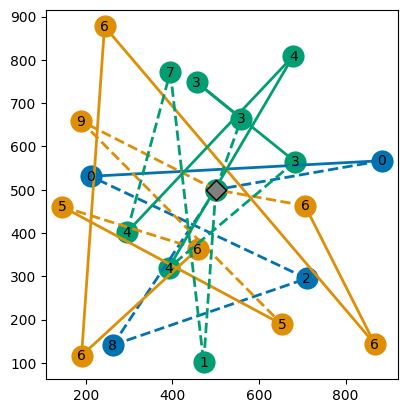

In [ ]:
nc = 20
nv = 3
nt = 10

pev = gerar_pev(nc, nv, nt)

for x in pev.tarefas:
  print(x)

taf = copy.deepcopy(pev.tarefas)
random.shuffle(taf)
for i in range(nv):
  pev.rotas[i] = taf[i*nt//nv:(i+1)*nt//nv]

plot_pev(pev)



## Algoritmo Guloso para o PEV

### População inicial

### Operadores de cruzamento

### Operadores de mutação

### Averiguando parâmetros

## Exercícios